# Análise da Bay Area Bike Share

## Introdução

[Bay Area Bike Share](http://www.bayareabikeshare.com/) é uma empresa que oferece aluguel de bicicletas on-demand para clientes em San Francisco, Redwood City, Palo Alto, Mountain View e San Jose. Os usuários podem desbloquear bicicletas de uma variedade de estações em cada cidade, e devolvê-las em qualquer estação dentro da mesma cidade. Os usuários pagam o serviço por meio de assinatura anual ou pela compra de passes de 3 dias ou 24 horas. Os usuários podem fazer um número ilimitado de viagens. Viagens com menos de trinta minutos de duração não têm custo adicional; Viagens mais longas incorrem em taxas de horas extras.

## Data Wrangling (Limpeza de Dados)

Os [dados abertos](http://www.bayareabikeshare.com/open-data) do Ano 1 e do Ano 2 da página Bay Area Bike Share vem em três partes: a primeira metade do Ano 1 (arquivos a partir de `201402`), a segunda metade do Ano 1 (arquivos a partir de `201408`) e todo o Ano 2 (arquivos a partir de `201508`). Existem três arquivos de dados principais associados a cada parte: dados de viagem que mostram informações sobre cada viagem no sistema (`*_trip_data.csv`), informações sobre as estações no sistema (`*_station_data.csv`).


Ao lidar com muitos dados, pode ser útil começar trabalhando com apenas uma amostra dos dados. Desta forma, será muito mais fácil verificar se nossos passos da limpeza de dados (Data Wrangling) estão funcionando, pois nosso código demorará menos tempo para ser concluído. Uma vez que estamos satisfeitos com a forma como funcionam as coisas, podemos configurar o processo para trabalhar no conjunto de dados como um todo.

Uma vez que a maior parte dos dados está contida na informação de viagem, devemos segmentar a procura de um subconjunto dos dados da viagem para nos ajudar a seguir em frente. Você começará olhando apenas o primeiro mês dos dados da viagem de bicicleta, de 2013-08-29 a 2013-09-30. O código abaixo selecionará os dados da primeira metade do primeiro ano, então escreverá o valor do primeiro mês de dados para um arquivo de saída. Este código explora o fato de que os dados são classificados por data (note que os dois primeiros dias são classificados por tempo de viagem, em vez de serem completamente cronológicos).

In [7]:
# Importa todas as bibliotecas necessárias
%matplotlib inline
import csv
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [8]:
# definição dos arquivos
file_in  = '201402_trip_data.csv'
file_out = '201309_trip_data.csv'

with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
    # configura o leitor de csv
    in_reader = csv.reader(f_in)
    out_writer = csv.writer(f_out)

    # escreve os dados no arquivo de saída até que a data limite seja atingida
    while True:
        datarow = next(in_reader)
        # data de início de das viagens na terceira coluna no formato 'm/d/yyyy HH:MM'
        if datarow[2][:9] == '10/1/2013':
            break
        out_writer.writerow(datarow)

### Condensando os Dados de Viagem

O primeiro passo é analisar a estrutura do conjunto de dados para ver se há alguma limpeza de dados que devemos realizar. A célula abaixo irá ler o arquivo de dados amostrado criado na célula anterior. Veja abaixo as primeiras linhas dessa tabela.

In [9]:
sample_data = pd.read_csv('201309_trip_data.csv')

sample_data.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


Nesta exploração, vamos nos concentrar nos fatores nos dados da viagem que afetam o número de viagens realizadas. Vamos focar em algumas colunas selecionadas: a duração da viagem (trip duration), hora de início (start time), terminal inicial (start terminal), terminal final (end terminal) e tipo de assinatura. O tempo de início será dividido em componentes de ano, mês e hora. Também adicionaremos uma coluna para o dia da semana e resumiremos o terminal inicial e final para ser a _cidade_ de início e fim.

Vamos primeiro abordar a última parte do processo de limpeza. Observe que o mapeamento da estação está configurado como uma função, `create_station_mapping()`. Uma vez que é possível que mais estações sejam adicionadas ou removidas ao longo do tempo, esta função nos permitirá combinar as informações da estação em todas as três partes dos nossos dados quando estivermos prontos para explorar tudo.

In [10]:
# Mostra as primeiras linhas do arquivo de dados das estações
station_info = pd.read_csv('201402_station_data.csv')
station_info.head()

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [11]:
# esta função será usada mais tarde para criar o mapeamento entre station e cidade
def create_station_mapping(station_data):
    """
    Cria um mapeamento (tambémm conhecido como de-para) entre a estação 
    e a cidade
    OBS: recebe um array de datafile de *_station_data.csv
    """
    
    station_map = {}
    for data_file in station_data:
        with open(data_file, 'r') as f_in:
            # configura o objeto csv reader - note que está sendo usado o DictReader,
            # que usa a primeira linha do arquivo como cabeçalho e cria as chaves
            # do dicionário com estes valores.
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                station_map[row['station_id']] = row['landmark']
    return station_map

# print (create_station_mapping(['201402_station_data.csv']));

Na sequência, será criado colunas para o ano, mês, hora e dia da semana.

In [12]:
def summarise_data(trip_in, station_data, trip_out):
    """
    Esta função recebe informações de viagem e estação e produz um novo
    arquivo de dados com um resumo condensado das principais informações de viagem.Os 
    argumentos trip_in e station_data serão listas de arquivos de dados para
    as informações da viagem e da estação enquanto trip_out especifica o local
    para o qual os dados sumarizados serão escritos.
    """
    # gera o dicionário de mapeamento entre estações e cidades
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # configura o objeto de escrita de csv       
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # configura o leitor do csv
                trip_reader = csv.DictReader(f_in)

                # processa cada linha lendo uma a uma
                for row in trip_reader:
                    new_point = {}
                    # converte a duração de segundos para minutos.
                    new_point['duration'] = int(row['Duration']) / 60
                    
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    
                    new_point['start_date']  = trip_date.strftime("%Y-%m-%d")
                    new_point['start_year']  = trip_date.strftime("%Y")
                    new_point['start_month'] = trip_date.strftime("%m")
                    new_point['start_hour']  = trip_date.strftime("%H")
                    new_point['weekday']     = trip_date.strftime("%A")
                    
                    new_point['start_city'] = station_map[row['Start Terminal']]
                    new_point['end_city'] = station_map[row['End Terminal']]
                    
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # escreve a informação processada para o arquivo de saída.
                    trip_writer.writerow(new_point)

O bloco de código abaixo usará os dados contidos nos arquivos listados nas variáveis `trip_in` e `station_data` e escreverá um novo arquivo no local especificado na variável `trip_out`.

In [13]:
# processe os dados usando a função criada acima
station_data = ['201402_station_data.csv']
trip_in = ['201309_trip_data.csv']
trip_out = '201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

In [14]:
# Carregue os dados novamente mostrando os dados
sample_data = pd.read_csv(trip_out)
display(sample_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,Thursday,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,Thursday,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,Thursday,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,Thursday,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,Thursday,San Francisco,San Francisco,Subscriber


## Análise Exploratória de Dados 

In [15]:
trip_data = pd.read_csv('201309_trip_summary.csv')

In [ ]:
print('Existem {:d} pontos no conjunto de dados'.format(trip_data.shape[0]))
print('A duração média das viagens foi de {:.2f} minutos'.format(trip_data['duration'].mean()))
print('A mediana das durações das viagens foi de {:.2f} minutos'.format(trip_data['duration'].median()))

duration_qtiles = trip_data['duration'].quantile([.25, .5, .75]).values()
print('25% das viagens foram mais curtas do que {:.2f} minutos'.format(duration_qtiles[0]))
print('25% das viagens foram mais compridas do que {:.2f} minutos'.format(duration_qtiles[2]))

Vemos que há mais de 27.000 viagens no primeiro mês e que a duração média da viagem é maior do que a duração mediana da viagem (o ponto em que 50% das viagens são mais curtas e 50% são mais longas). Na verdade, a média é maior que as durações de 75% das viagens mais curtas. Isso será interessante para ver mais adiante.

Vamos começar a ver como essas viagens são divididas por tipo de inscrição. Uma maneira fácil de construir uma intuição sobre os dados é traçá-los.

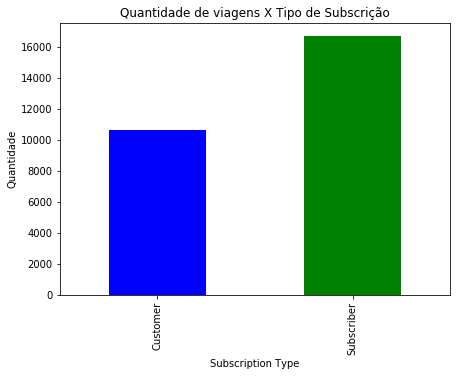

In [17]:
colors = ['blue', 'green'];
title='Quantidade de viagens X Tipo de Subscrição';
# Agrupa os valores pelo tipo de subscrição e obtem a quantidade de uma coluna qualquer
quantity_subscription_data = trip_data.groupby('subscription_type').count()['duration']
# Monta o gráfico
quantity_subscription_graph = quantity_subscription_data.plot(kind='bar', title=title, color=colors, figsize=(7, 5))
# Define o título do eixo X
quantity_subscription_graph.set_xlabel("Subscription Type")
# Define o título do eixo Y
quantity_subscription_graph.set_ylabel("Quantidade")
# Exibe o gráfico
quantity_subscription_graph

Parece que existe 50% mais viagens feitas por assinantes (subscribers) no primeiro mês do que outro tipos de consumidores. Vamos tentar uma outra variável. Como é a distribuição da duração das viagens (trip duration)?

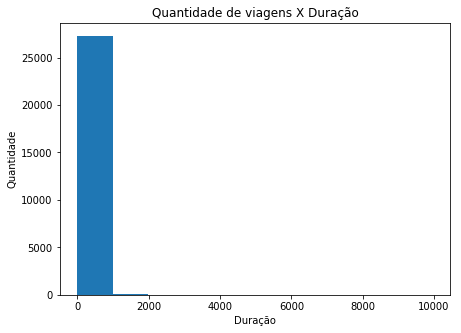

In [18]:
# Define um título
title='Quantidade de viagens X Duração';
# Obtem os dados das durações das viagens
quantity_duration_data = trip_data['duration']
# Monta um gráfico com o dado obtido
quantity_duration_graph = quantity_duration_data.plot(kind='hist', title=title, figsize=(7, 5))
# Define o título do eixo X
quantity_duration_graph.set_xlabel("Duração")
# Define o título do eixo Y
quantity_duration_graph.set_ylabel("Quantidade")
# Exibe o gráfico
quantity_duration_graph

Parece muito estranho, não é? Dê uma olhada nos valores de duração no eixo x. A maioria dos passeios deve ser de 30 minutos ou menos, uma vez que há taxas de excesso de tempo extra em uma única viagem. A primeira barra abrange durações de até 1000 minutos, ou mais de 16 horas. Com base nas estatísticas que obtivemos deveríamos ter esperado algumas viagens com durações muito longas que levem a média a ser muito superior à mediana: o gráfico mostra isso de forma dramática, mas inútil.

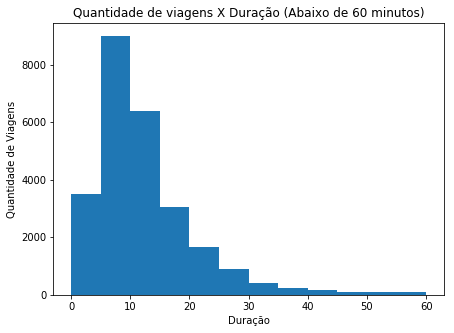

In [19]:
# Define um título
title='Quantidade de viagens X Duração (Abaixo de 60 minutos)';
# Obtem os dados das durações das viagens
new_quantity_duration_data = trip_data.query('duration <= 60')['duration']
# Define os intervalos a serem considerados no histograma
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
# Monta um gráfico com o dado obtido
new_quantity_duration_graph = new_quantity_duration_data.plot(kind='hist', title=title, figsize=(7, 5), bins=bins)
# Define o título do eixo X
new_quantity_duration_graph.set_xlabel("Duração")
# Define o título do eixo Y
new_quantity_duration_graph.set_ylabel("Quantidade de Viagens")
# Exibe o gráfico
new_quantity_duration_graph

Isto está bem melhor! Podemos ver que a maioria das viagens abrange durações de 5 a 10 minutos. Na verdade, esse período é representante de 35% das viagens análisadas tendo um valor absoluto de 9025 viagens.


In [20]:
trip_data_between_5_and_10 = trip_data.query('duration >= 5').query('duration <= 10')
print ("A quantidade total de viagens foi: ")
print ((trip_data_between_5_and_10.count()['duration']))
trip_data_between_5_and_10.groupby(['start_city', 'end_city']).count()['duration']


A quantidade total de viagens foi: 
9025


start_city     end_city     
Mountain View  Mountain View     105
Palo Alto      Palo Alto          50
Redwood City   Redwood City       66
San Francisco  San Francisco    8129
San Jose       San Jose          675
Name: duration, dtype: int64

Interessante, podemos reparar que a maior parte dos usuários do programa são da cidade de San Francisco.

## Juntando tudo
Agora vamos unir todos os dados em um mesmo arquivo, para analisar todos os dados disponíveis.

In [21]:
station_data = ['201402_station_data.csv',
                '201408_station_data.csv',
                '201508_station_data.csv' ]
trip_in = ['201402_trip_data.csv',
           '201408_trip_data.csv',
           '201508_trip_data.csv' ]
trip_out = 'babs_y1_y2_summary.csv'

# Esta função irá ler as informações das estações e das viagens
# e escreverá um arquivo processado com o nome trip_out
summarise_data(trip_in, station_data, trip_out)

Podemos ver que a função `summarise_data()` escreveu um arquivo de saída, sendo assim, temos um novo arquivo para trabalhar.

In [22]:
trip_data = pd.read_csv('babs_y1_y2_summary.csv')
display(trip_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,Thursday,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,Thursday,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,Thursday,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,Thursday,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,Thursday,San Francisco,San Francisco,Subscriber


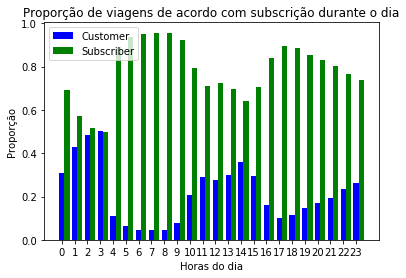

In [23]:
# Porcentagem de uso do BABS durante as horas do dia, agrupando pelo tipo de subscrição
hours_subscription_count = trip_data.groupby(['subscription_type', 'start_hour']).count()['duration']

customer_count = hours_subscription_count['Customer']
subscriber_count = hours_subscription_count['Subscriber']

hours_subscription_total = trip_data.groupby(['start_hour']).count()['duration']

customer_proportions = customer_count / hours_subscription_total
subscriber_proportions = subscriber_count / hours_subscription_total

width = 0.4
n = 24
X = np.arange(n)

plt.bar(X, customer_proportions, width, color='b', label='Customer')
plt.bar(X + width, subscriber_proportions, width, color='g', label='Subscriber')
plt.title('Proporção de viagens de acordo com subscrição durante o dia')
plt.ylabel('Proporção')
plt.xlabel('Horas do dia')
plt.xticks(X)
plt.legend()

Pelo gráfico exibido acima, podemos perceber que o uso do Bay Area Bike Share é majoritario pelos subscribers durante o dia todo. Mas podemos perceber que curiosamente durantes a madrugrada e o meio da tarde os costumers tendem a utilizar mais o serviço. Isso pode se dever ao fato da grande movimentação em horários de pico possívelmente assustar os costumers, momentos como início e término de expedientes por volta das 7 e 17h tem menores procuras pelos costumers.

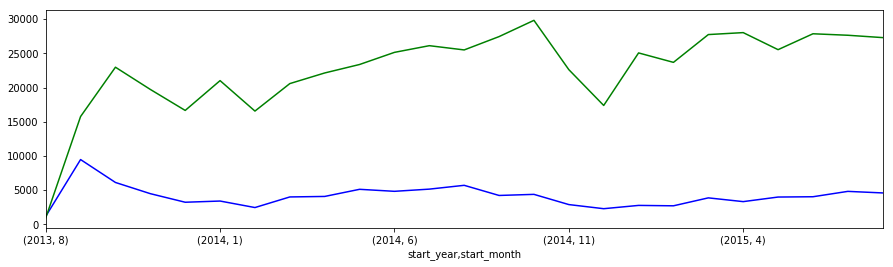

In [24]:
popularity = trip_data.groupby(['subscription_type', 'start_year', 'start_month']).count()['duration']
costumer_popularity = popularity['Customer']
subscriber_popularity = popularity['Subscriber']

costumer_popularity.plot(color='b', figsize=(15,4))
subscriber_popularity.plot(color='g')


Podemos notar que a quantidade de usuários subscribers aumentou muito nos últimos meses de 2013, mas o que isso significa para a porcentagem das viagens do serviço?

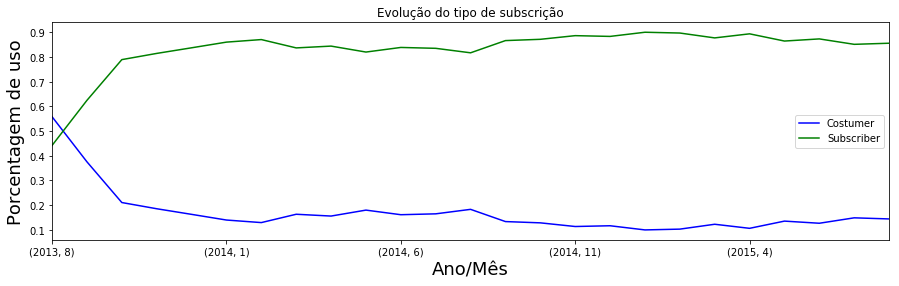

In [25]:
popularity_total = trip_data.groupby(['start_year', 'start_month']).count()['duration']

costumer_proportions = costumer_popularity / popularity_total
subscriber_proportions = subscriber_popularity / popularity_total

costumer_proportions.plot(color='b', figsize=(15,4), label='Costumer')
subscriber_proportions.plot(color='g', label='Subscriber')
plt.title('Evolução do tipo de subscrição');
plt.xlabel('Ano/Mês', fontsize=18);
plt.ylabel('Porcentagem de uso', fontsize=18);
plt.legend()

Agora sim, nessa ultima vizualização, vemos claramente que o serviço tem 90% de seus clientes como subscribers e a popularidade entre os costumers caiu desde o final de 2013. Esse tipo de análise me parece importante para que a empresa saiba a quem focar alterações e melhoria dos serviços. Claramente a empresa fidelizou seus clientes logo no começo dos dados análisados, seria interessante obter dados anteriores aos disponibilizados para que pudessemos observar como foi esse período de fidelização, antes de ocorrer a grande virada em novembro de 2013.